# Basic Application direct Alveo to Alveo

This notebook shows you how to use the ***basic*** Vitis network example in an direct Alveo to Alveo scenario

In this Notebook we will transfer a few images from one Alveo to the another Alveo card

This notebook assumes:
* Direct connection between the Alveo cards
* Dask cluster is already created and running. For more information about setting up a Dask cluster visit the [Dask documentation](https://docs.dask.org/en/latest/setup.html)

## Connect to the Dask cluster
1. Connect to the Dask cluster
1. Grab workers name
1. Check if there are two workers available

In [14]:
# from dask.distributed import Client, get_client

# client = Client("tcp://10.1.212.129:8786")
# client

In [15]:
# client_info = client.scheduler_info()['workers']
# workers = []
# for cli in client_info:
#     workers.append(client_info[cli]['name'])

# if len(workers) != 2:
#     print("Configure your Dask cluster with two workers")

## Basic remote functions
In this part we are going to schedule a basic function to the workers to verify that we are able to pinpoint tasks to a particular worker, we are also going to grab the Alveo shell name.
You should visually check that your xclbin file is built for the Alveo shell available on the workers.

In [16]:
# import platform, os

# def verify_workers():
#     node_name = platform.node()
#     shell_version = os.popen("xbutil dump | grep dsa_name").read()
#     #match = True
#     #if 'xilinx_u280_xdma_201920_3' not in shell_version:
#     #    match = False
#     return node_name, shell_version[24:-2]

# worker_0 = client.submit(verify_workers ,workers=workers[0], pure=False)
# worker_1 = client.submit(verify_workers ,workers=workers[1], pure=False)

# worker_check = [worker_0.result(),worker_1.result()]

# for w in worker_check:
#     print('Worker name: {} | shell version: {}'.format(w[0],w[1]))

## Source Dask device and utilities

In this section we will import the libraries and dask on pynq class which allow us to:

* Download a `xclbin` file to a worker
* Peek and poke registers
* Allocate buffers
* Start kernels

All of these capabilities are available for both local and remote workers

In [17]:
from vnx_utils import *
import pynq
import platform, os
%run dask_pynq.py

## Download xclbin to workers
1. Create Dask device for each worker
2. Create an overlay object for each worker, this step will download the `xclbin` file to the Alveo card

In [18]:
# daskdev_w0 = DaskDevice(client, workers[0])
# daskdev_w1 = DaskDevice(client, workers[1])

# xclbin = '../basic.intf3.xilinx_u280_xdma_201920_3/vnx_basic_if3.xclbin'
# ol_w0 = pynq.Overlay(xclbin, device=daskdev_w0)
# ol_w1 = pynq.Overlay(xclbin, device=daskdev_w1)

for i in range(len(pynq.Device.devices)):
    print("{}) {}".format(i, pynq.Device.devices[i].name))

xclbin = '../basic.intf3.xilinx_u280_xdma_201920_3/vnx_basic_if3.xclbin'
ol_w0 = pynq.Overlay(xclbin,device=pynq.Device.devices[0])
ol_w1 = pynq.Overlay(xclbin,device=pynq.Device.devices[1])
ol_w0.ip_dict
ol_w1.ip_dict

0) xilinx_u280_xdma_201920_3
1) xilinx_u280_xdma_201920_3


{'cmac_0': {'phys_addr': 25165824,
  'addr_range': 8192,
  'type': 'xilinx.com:kernel:cmac_0:1.0',
  'hw_control_protocol': 'ap_ctrl_none',
  'fullpath': 'cmac_0',
  'registers': {'gt_reset_reg': {'address_offset': 0,
    'access': 'read-write;',
    'size': 32,
    'host_size': 4,
    'description': 'OpenCL Argument Register',
    'type': 'uint',
    'id': 0},
   'reset_reg': {'address_offset': 4,
    'access': 'read-write;',
    'size': 32,
    'host_size': 4,
    'description': 'OpenCL Argument Register',
    'type': 'uint',
    'id': 1},
   'mode': {'address_offset': 8,
    'access': 'read-write;',
    'size': 32,
    'host_size': 4,
    'description': 'OpenCL Argument Register',
    'type': 'uint',
    'id': 2},
   'conf_tx': {'address_offset': 12,
    'access': 'read-write;',
    'size': 32,
    'host_size': 4,
    'description': 'OpenCL Argument Register',
    'type': 'uint',
    'id': 3},
   'conf_rx': {'address_offset': 20,
    'access': 'read-write;',
    'size': 32,
    'hos

## Check Link 

We are going to use the function `link_status` that reports if the CMAC is detecting link, which means that the physical connection
between the two Alveo cards is established.

In [19]:
print("Link worker 0 {}; link worker 1 {}".format(ol_w0.cmac_1.link_status(),ol_w1.cmac_1.link_status()))

Link worker 0 {'cmac_link': True}; link worker 1 {'cmac_link': True}


### Configure remote Alveo card

1. Set up IP address and MAC address
2. Set up connection table
3. Launch ARP discovery
4. Print out ARP Table 

In [20]:
print(ol_w1.networklayer_0.set_ip_address('192.168.0.10', debug=True))
#2
ol_w1.networklayer_0.sockets[7] = ('192.168.0.5', 62177, 60512, True)
ol_w1.networklayer_0.populate_socket_table()
#3 
ol_w1.networklayer_0.arp_discovery()
#4
ol_w1.networklayer_0.get_arp_table()

# print(ol_w1.networklayer_1.set_ip_address('192.168.0.10', debug=True))
# #2
# ol_w1.networklayer_1.sockets[7] = ('192.168.0.5', 62177, 60512, True)
# print(ol_w1.networklayer_1.register_map.mac_address.address)
# print(ol_w1.networklayer_1.register_map.ip_address.address)
# print(ol_w1.networklayer_1.register_map.gateway.address)
# print(ol_w1.networklayer_1.register_map.ip_mask.address)
# print(ol_w1.networklayer_1.register_map.eth_in_cycles.address)
# print(ol_w1.networklayer_1.register_map.eth_in_bytes.address)
# print(ol_w1.networklayer_1.register_map.eth_in_packets.address)
# print(ol_w1.networklayer_1.register_map.pkth_in_cycles.address)
# print(ol_w1.networklayer_1.register_map.pkth_in_bytes.address)
# print(ol_w1.networklayer_1.register_map.pkth_in_packets.address)
# print(ol_w1.networklayer_1.register_map.arp_in_cycles.address)
# print(ol_w1.networklayer_1.register_map.arp_in_bytes.address)
# print(ol_w1.networklayer_1.register_map.arp_in_packets.address)
# print(ol_w1.networklayer_1.register_map.arp_out_cycles.address)
# print(ol_w1.networklayer_1.register_map.arp_out_bytes.address)
# print(ol_w1.networklayer_1.register_map.arp_out_packets.address)
# print(ol_w1.networklayer_1.register_map.icmp_in_cycles.address)
# print(ol_w1.networklayer_1.register_map.icmp_in_bytes.address)
# print(ol_w1.networklayer_1.register_map.icmp_in_packets.address)
# print(ol_w1.networklayer_1.register_map.icmp_out_cycles.address)
# print(ol_w1.networklayer_1.register_map.icmp_out_bytes.address)
# print(ol_w1.networklayer_1.register_map.icmp_out_packets.address)
# print(ol_w1.networklayer_1.register_map.ethhi_out_cycles.address)
# print(ol_w1.networklayer_1.register_map.ethhi_out_bytes.address)
# print(ol_w1.networklayer_1.register_map.ethhi_out_packets.address)
# print(ol_w1.networklayer_1.register_map.eth_out_cycles.address)
# print(ol_w1.networklayer_1.register_map.eth_out_bytes.address)
# print(ol_w1.networklayer_1.register_map.eth_out_packets.address)
# print(ol_w1.networklayer_1.register_map.udp_in_cycles.address)
# print(ol_w1.networklayer_1.register_map.udp_in_bytes.address)
# print(ol_w1.networklayer_1.register_map.udp_in_packets.address)
# print(ol_w1.networklayer_1.register_map.app_out_cycles.address)
# print(ol_w1.networklayer_1.register_map.app_out_bytes.address)
# print(ol_w1.networklayer_1.register_map.app_out_packets.address)
# print(ol_w1.networklayer_1.register_map.udp_out_cycles.address)
# print(ol_w1.networklayer_1.register_map.udp_out_bytes.address)
# print(ol_w1.networklayer_1.register_map.udp_out_packets.address)
# print(ol_w1.networklayer_1.register_map.app_in_cycles.address)
# print(ol_w1.networklayer_1.register_map.app_in_bytes.address)
# print(ol_w1.networklayer_1.register_map.app_in_packets.address)
# print(ol_w1.networklayer_1.register_map.debug_reset_counters.address)
# print(ol_w1.networklayer_1.register_map.udp_theirIP_offset.address)
# print(ol_w1.networklayer_1.register_map.udp_theirPort_offset.address)
# print(ol_w1.networklayer_1.register_map.udp_myPort_offset.address)
# print(ol_w1.networklayer_1.register_map.udp_valid_offset.address)
# print(ol_w1.networklayer_1.register_map.udp_number_sockets.address)
# print(ol_w1.networklayer_1.register_map.arp_discovery.address)
# print(ol_w1.networklayer_1.register_map.arp_valid_offset.address)
# print(ol_w1.networklayer_1.register_map.arp_ip_addr_offset.address)
# print(ol_w1.networklayer_1.register_map.arp_mac_addr_offset.address)
# print(ol_w1.networklayer_1.register_map)
# for i in range(2000, 3000, 4):
# #     print(i, ol_w1.networklayer_1.read(ol_w1.networklayer_1.register_map.udp_number_sockets.address+i))
# ol_w1.networklayer_0.populate_socket_table()
# #3 
# ol_w1.networklayer_0.arp_discovery()
# #4
# ol_w1.networklayer_0.get_arp_table()

{'HWaddr': '00:0a:35:02:9d:0a', 'inet addr': '192.168.0.10', 'gateway addr': '192.168.0.1', 'Mask': '255.255.255.0'}


{5: {'MAC address': '00:0a:35:02:9d:e5', 'IP address': '192.168.0.5'}}

### Configure local Alveo card

1. Print out IP and MAC address
2. Set up connection table
3. Launch ARP discovery
4. Print out ARP Table 

In [21]:
print(ol_w0.networklayer_0.get_network_info())
#2
ol_w0.networklayer_0.sockets[3] = ('192.168.0.10', 60512, 62177, True)
ol_w0.networklayer_0.populate_socket_table()
#3 
ol_w0.networklayer_0.arp_discovery()
#4
ol_w0.networklayer_0.get_arp_table()
# print(ol_w0.networklayer_1.get_network_info())
# #2
# ol_w0.networklayer_1.sockets[3] = ('192.168.0.10', 60512, 62177, True)
# ol_w0.networklayer_1.populate_socket_table()
# #3 
# ol_w0.networklayer_1.arp_discovery()
# #4
# ol_w0.networklayer_1.get_arp_table()

{'HWaddr': '00:0a:35:02:9d:e5', 'inet addr': '192.168.0.5', 'gateway addr': '192.168.0.1', 'Mask': '255.255.255.0'}


{10: {'MAC address': '00:0a:35:02:9d:0a', 'IP address': '192.168.0.10'}}

## Get an image to transfer

In [22]:
filename = 'image.jpg'
if not os.path.exists(filename):
    !wget -O $filename -q https://cdn.pixabay.com/photo/2022/05/23/11/26/tree-7215935_960_720.jpg

In [23]:
from PIL import Image
image = Image.open(os.getcwd()+'/'+filename)
img_width, img_height = image.size

## Configure the application

* Define kernel alias
* Allocate remote and local buffers.
* Initialize the remote buffer with the image and move it 

In [24]:
mm2s_remote = ol_w1.krnl_mm2s_0
s2mm_local = ol_w0.krnl_s2mm_0
size = img_height * img_width * 3

# mm2s_remote = ol_w1.krnl_mm2s_1
# s2mm_local = ol_w0.krnl_s2mm_1

s2mm_bank = ol_w0.HBM0
mm2s_bank = ol_w1.HBM0

s2mm_buf = pynq.allocate(size, dtype=np.uint8, target=s2mm_bank)
mm2s_buf = pynq.allocate(size, dtype=np.uint8, target=mm2s_bank)

mm2s_buf[:] = np.reshape(np.array(image), size)

mm2s_buf.sync_to_device()

## Start kernels

1. Start local kernel
2. Start remote kernel which will start sending the image to ID=7

In [25]:
s2mm_wh = s2mm_local.start(s2mm_buf,size)

mm2s_remote.start(mm2s_buf, size, 7)

Wait local kernel to finish and show results

In [26]:
s2mm_wh.wait()
s2mm_buf.sync_from_device()

## Verify communication

In [27]:
msg = "Yes!" if np.array_equal(mm2s_buf, s2mm_buf) else "No!"
print("Are images equal? {}".format(msg))

Are images equal? No!


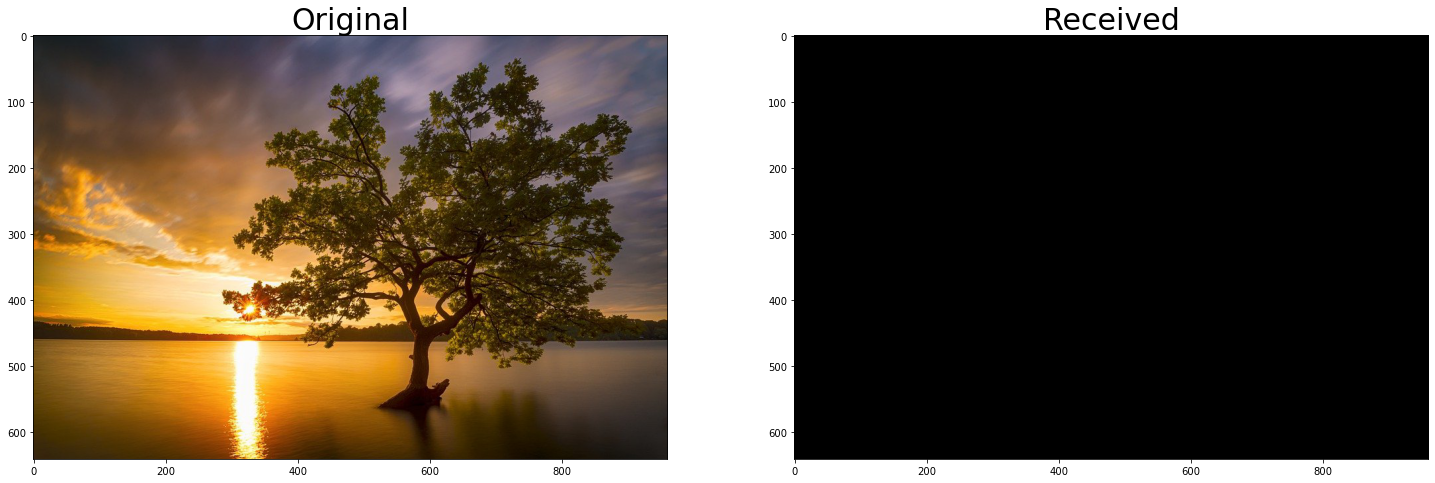

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
image_received = np.reshape(s2mm_buf, np.shape(image))
fig = plt.figure(figsize=(25,25))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set_title('Original', fontsize=30)
ax2.set_title('Received', fontsize=30)
ax1.imshow(image)
ax2.imshow(image_received)

In [29]:
print(ol_w0.networklayer_0.register_map)

RegisterMap {
  mac_address = Register(value=43839036901),
  ip_address = Register(value=3232235525),
  gateway = Register(value=3232235521),
  ip_mask = Register(value=4294967040),
  eth_in_cycles = Register(value=962676239281),
  eth_in_bytes = Register(value=30720),
  eth_in_packets = Register(value=512),
  pkth_in_cycles = Register(value=962676239281),
  pkth_in_bytes = Register(value=30720),
  pkth_in_packets = Register(value=512),
  arp_in_cycles = Register(value=962676239281),
  arp_in_bytes = Register(value=30720),
  arp_in_packets = Register(value=512),
  arp_out_cycles = Register(value=962707340001),
  arp_out_bytes = Register(value=30720),
  arp_out_packets = Register(value=512),
  icmp_in_cycles = Register(value=0),
  icmp_in_bytes = Register(value=0),
  icmp_in_packets = Register(value=0),
  icmp_out_cycles = Register(value=0),
  icmp_out_bytes = Register(value=0),
  icmp_out_packets = Register(value=0),
  ethhi_out_cycles = Register(value=0),
  ethhi_out_bytes = Register(

## Query embedded debug probes

In [30]:
def showDebugProbes(tg, freq = 300.0, direction= 'rx'):
    
    if direction not in ['rx', 'tx']:
        raise ValueError("Only 'rx' and 'tx' strings are supported \
            on direction argument")
    tot_bytes, tot_cycles, tot_pkts = 0, 0, 0
    if direction == 'tx':
        tot_bytes  = int(tg.register_map.udp_out_bytes) 
        tot_cycles = int(tg.register_map.udp_out_cycles)
        tot_pkts   = int(tg.register_map.udp_out_packets)
    else:
        tot_bytes  = int(tg.register_map.udp_in_bytes) 
        tot_cycles = int(tg.register_map.udp_in_cycles)
        tot_pkts   = int(tg.register_map.udp_in_packets)
    try:
        tot_time   = (1 / (freq*10**6)) * tot_cycles
        thr_bs     = (tot_bytes * 8) / tot_time
    except ZeroDivisionError:
        tot_time = 0
        thr_bs = 0
    print(tot_bytes)
    print(tot_cycles)
    print(tot_time)
    print("{} app: total payload packets {:,}\tbytes {:,}\t throughput {:.6f} Gbps"\
         .format(direction, tot_pkts, tot_bytes, thr_bs/(10**9)))

showDebugProbes(ol_w0.networklayer_0,freq = 300)
showDebugProbes(ol_w1.networklayer_0,freq = 300, direction= 'tx')

0
0
0
rx app: total payload packets 0	bytes 0	 throughput 0.000000 Gbps
0
0
0
tx app: total payload packets 0	bytes 0	 throughput 0.000000 Gbps


## Release Alveo cards
To release the Alveo cards the pynq overlay is freed

In [ ]:
del s2mm_buf
del mm2s_buf
pynq.Overlay.free(ol_w0)
pynq.Overlay.free(ol_w1)

------------------------------------------
Copyright (c) 2021, Xilinx, Inc.